# Optimización de carteras de inversión - LSTM

Continuando con la línea de investigación en la optimización de carteras, en este notebook abordaremos el uso de redes neuronales de tipo **LSTM** (Long Short-Term Memory) como herramienta para mejorar la predicción del rendimiento de los activos financieros. Las LSTM son una variante de redes neuronales recurrentes (RNN) que son especialmente efectivas para capturar dependencias a largo plazo en secuencias de datos, lo que las convierte en una elección ideal para el análisis temporal de precios de activos. A través de esta metodología, buscamos proporcionar un enfoque complementario a la **Teoría Moderna de la Cartera** (Modern Portfolio Theory - MPT), permitiendo una evaluación más profunda de los patrones de rendimiento de los activos. 

## Funcionamiento Básico de las LSTM

Las LSTM son redes recurrentes que superan la limitación de las RNN tradicionales para manejar dependencias de largo plazo. En las redes recurrentes tradicionales (RNN), existe un problema llamado **desvanecimiento del gradiente** (*vanishing gradient*), lo cual hace que estas redes no sean efectivas para aprender dependencias a largo plazo. Las LSTM se diseñaron para resolver este problema al agregar una **memoria a largo plazo** que controla el flujo de información a través de un conjunto de puertas (olvido, entrada y salida). Los componentes principales son:

1.	**Forget Gate (Puerta de Olvido,  $f_t$ )**: Esta parte decide cuánta información del pasado se va a olvidar. Por ejemplo, si cierta información ya no es relevante, la LSTM puede decidir descartarla. Esta puerta utiliza una función sigmoide (σ) que produce valores entre 0 y 1 para determinar qué tanta información olvidar (0 = olvidar todo, 1 = mantener todo).
2.	**Input Gate (Puerta de Entrada,  $i_t$ )**: Decide qué parte de la nueva información que entra debe almacenarse. También usa una función sigmoide para controlar qué información del estado actual es importante para recordar.
3.	**Candidate Gate (Puerta Candidata,  $\tilde{C_t}$ )**: Esta parte genera una nueva información candidata que podría ser agregada al estado de la celda actual. La información candidata es transformada por una función  $\tanh$ , que comprime los valores entre -1 y 1.
4.	**State Cell (Estado de la Celda,  $C_t$)**: Es el núcleo de la memoria de la LSTM. Aquí se almacena la información a largo plazo. Las decisiones tomadas por las puertas de olvido e ingreso afectan el valor de esta celda, actualizando lo que la LSTM “recuerda” de un paso temporal a otro.
5.	**Output Gate (Puerta de Salida,  $o_t$ )**: Controla qué información se debe enviar a la salida (estado oculto o  $h_t$) para la siguiente capa o paso de tiempo. También usa una función sigmoide y modula el valor del estado de la celda con una función  $\tanh$.


Las LSTM se entrenan utilizando **retropropagación a través del tiempo (BPTT)**, un algoritmo de entrenamiento especial para redes recurrentes. BPTT actualiza los pesos de la red en función de las dependencias entre los datos en diferentes pasos de tiempo.

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/5/53/Peephole_Long_Short-Term_Memory.svg" alt="Peephole Long Short-Term Memory" width="400"/>
</p>

*Image by [Chris Olah](https://commons.wikimedia.org/wiki/File:Peephole_Long_Short-Term_Memory.svg) licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en).*

## Composición de la cartera

Utilizaremos las mismas carteras de **large cap**, **mid cap** y **small cap**, y el **S&P 500** como benchmark, con los mismos datos históricos utilizados en las pruebas de `app.R`. Esto nos permitirá mantener una coherencia y comparabilidad entre los análisis anteriores y este enfoque optimizado. Recordemos la composición de las carteras:

* Large Cap = ["MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOGL", "LLY", "AVGO", "JPM", "TSLA", "WMT", "XOM", "MA", "V", "UNH"]
* Mid Cap = ["ADSK", "AIG", "AJG", "APD", "DHI", "FTNT", "GM", "GWW", "MET", "MMM", "ODFL", "PSA", "TFC", "TRV", "WELL"]
* Small Cap = ["AAL", "MTCH", "MKTX", "PNW", "FRT", "CHRW", "GNRC", "BWA", "RHI", "HAS", "MHK", "RL", "BIO", "FMC", "IVZ"]

Originalmente, el periodo temporal era 2013-01-01 a 2023-12-29, separado en dos subperiodos: para el conjunto de datos de entrenamiento el 70% de los datos, correspondiendo con el periodo 2013-01-01 a 2020-09-10 y para la evaluación, el 30% restante, desde 2020-09-10 a 2023-12-29. En nuestro caso, tendremos un conjunto de datos de entrenamiento del 2013-01-01 al 2017-09-10, un conjunto de validación del 2017-09-10 al 2020-09-10, y un conjunto de prueba desde 2020-09-10 a 2023-12-29, para poder comparar los resultados obtenidos.

* *Nota: Habitualmente, los datos se dividen en proporciones estándar, como un 70% para entrenamiento, un 15% para validación y un 15% para prueba. Sin embargo, en este caso, hemos ajustado las fechas de los conjuntos de datos para mantener la coherencia con análisis previos ya realizados, asegurándonos de que los resultados sean comparables.*

Por lo tanto, el objetivo es utilizar una red neuronal LSTM para predecir los precios de los activos. A partir de estas predicciones, se calculará el rendimiento de la cartera y se optimizarán los pesos de los activos con el fin de maximizar el Ratio de Sharpe. Primero descargaremos los datos de Yahoo Finance con yfinance.

In [ ]:
import yfinance as yf
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

large_cap = ["MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOGL", "LLY", "AVGO", "JPM", "TSLA", "WMT", "XOM", "MA", "V", "UNH"]
mid_cap = ["ADSK", "AIG", "AJG", "APD", "DHI", "FTNT", "GM", "GWW", "MET", "MMM", "ODFL", "PSA", "TFC", "TRV", "WELL"]
small_cap = ["AAL", "MTCH", "MKTX", "PNW", "FRT", "CHRW", "GNRC", "BWA", "RHI", "HAS", "MHK", "RL", "BIO", "FMC", "IVZ"]
data_lc = yf.download(large_cap, start='2013-01-01', end='2023-12-29')['Close']
data_mc = yf.download(mid_cap, start='2013-01-01', end='2023-12-29')['Close']
data_sc = yf.download(small_cap, start='2013-01-01', end='2023-12-29')['Close']

In [223]:
data_sc.head()

Ticker,AAL,BIO,BWA,CHRW,FMC,FRT,GNRC,HAS,IVZ,MHK,MKTX,MTCH,PNW,RHI,RL
Date,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,13.98,107.459999,32.794895,63.160000,51.535126,105.320000,35.200001,35.820000,26.959999,93.169998,36.230000,13.420902,52.400002,32.560001,152.100006
2013-01-03 00:00:00+00:00,13.66,107.519997,32.742077,62.340000,51.092800,104.500000,34.630001,36.119999,27.010000,93.269997,35.759998,13.275271,52.360001,32.880001,157.210007
2013-01-04 00:00:00+00:00,14.73,108.610001,32.477993,63.040001,51.283607,105.169998,34.709999,35.740002,27.559999,93.519997,34.959999,13.403769,52.400002,33.410000,159.389999
2013-01-07 00:00:00+00:00,14.84,109.070000,32.345951,63.150002,51.994797,105.709999,34.669998,35.349998,27.480000,92.739998,35.220001,13.143918,51.889999,32.660000,161.520004
2013-01-08 00:00:00+00:00,15.16,109.320000,31.905809,63.209999,52.393757,104.769997,34.639999,35.380001,27.230000,93.300003,35.330002,12.981154,51.939999,32.619999,162.250000


In [ ]:
import plotly.express as px

def plot_portfolio(data, title):

    data_long = data.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Precio')
    fig = px.line(data_long, x='Date', y='Precio', color='Ticker', title=title)
    fig.show()

plot_portfolio(data_lc, 'Precios de Cierre Ajustados - Large Cap (2013-2023)')
plot_portfolio(data_mc, 'Precios de Cierre Ajustados - Mid Cap (2013-2023)')
plot_portfolio(data_sc, 'Precios de Cierre Ajustados - Small Cap (2013-2023)') 

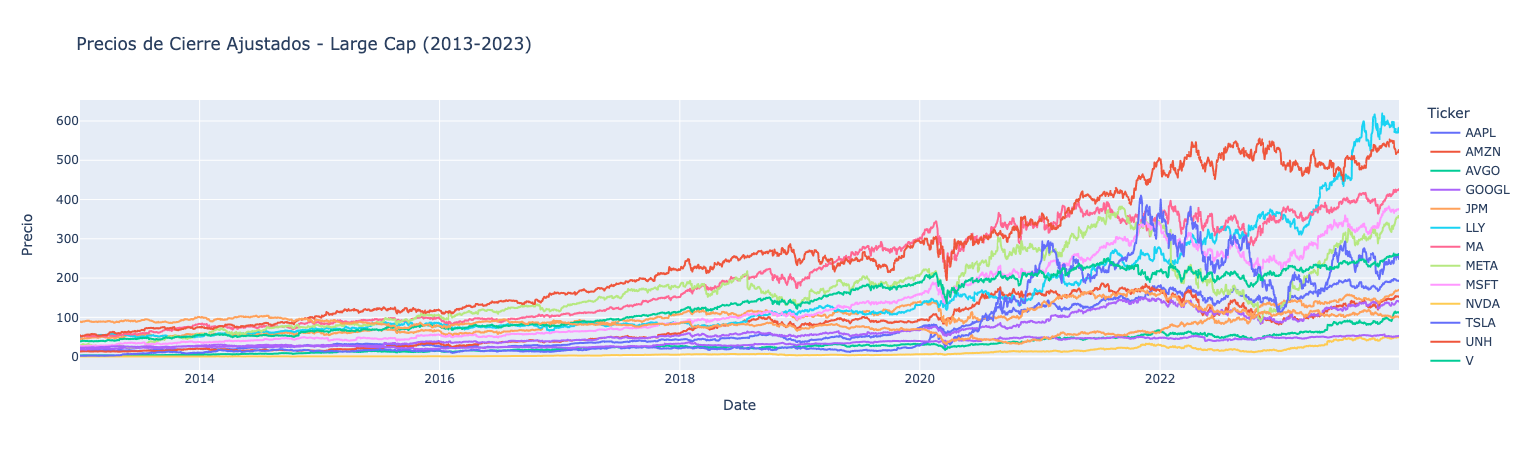

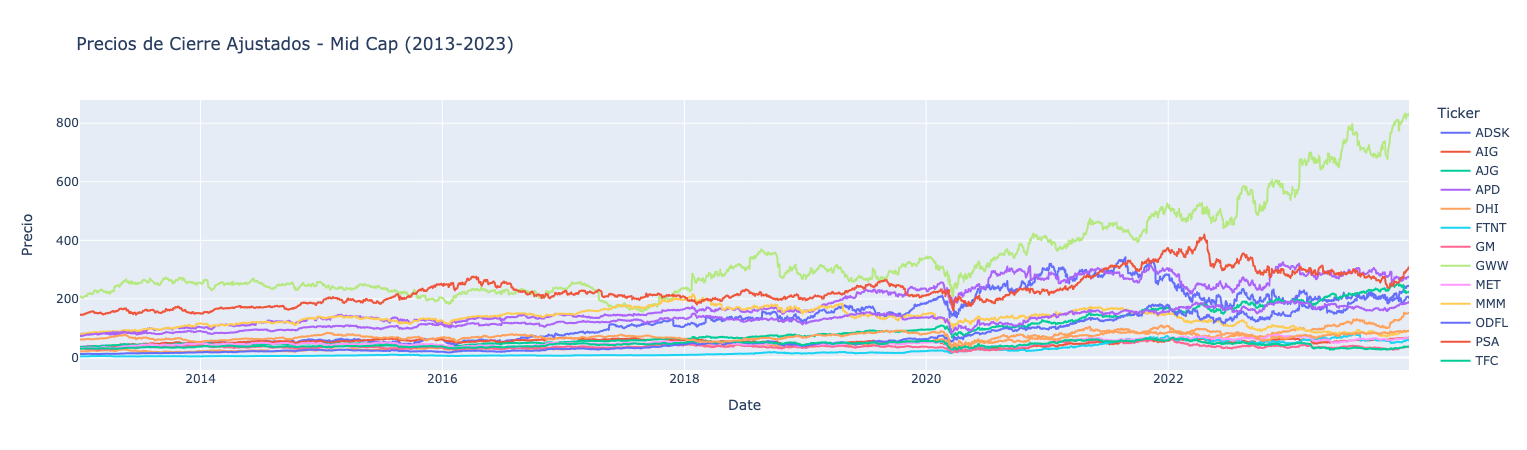

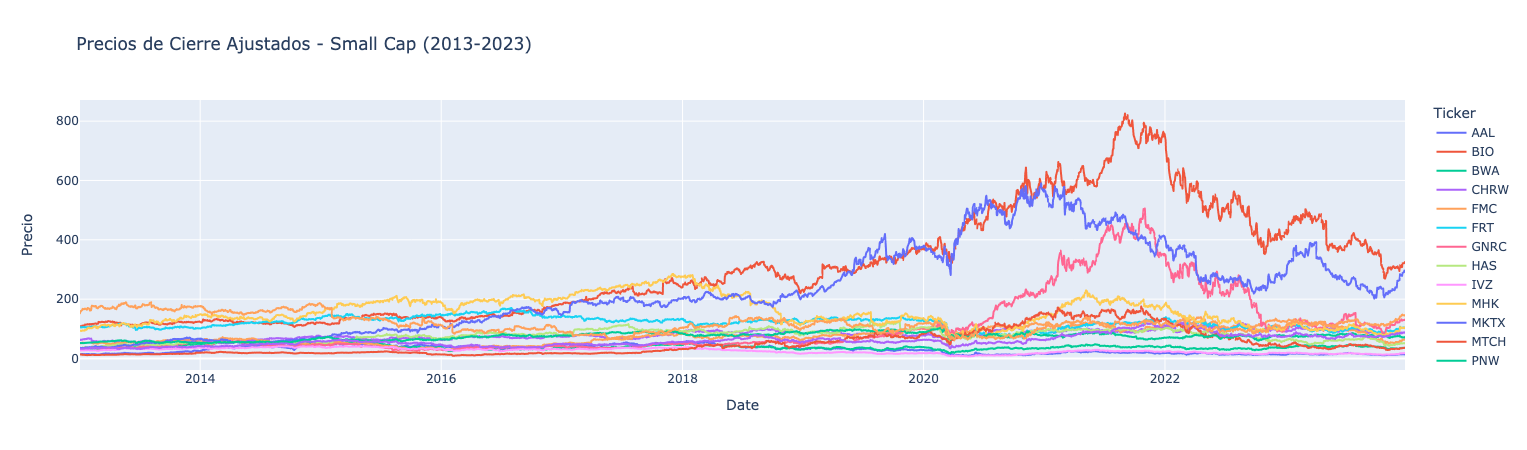

In [4]:
display(Image(filename='./images/02_lstm.png'))
display(Image(filename='./images/03_lstm.png'))
display(Image(filename='./images/04_lstm.png'))

Al observar los gráficos, notamos una clara diferencia en los precios de cierre entre los distintos activos. Entrenar una red neuronal para cada activo tiene sentido si el objetivo es hacer una predicción individualizada de precios para cada uno. Dado que cada activo puede tener patrones únicos, entrenar modelos separados permitiría que cada red aprenda mejor las particularidades de cada activo. Aun así, nuestro enfoque es predecir de manera conjunta el comportamiento de una cartera, por lo que usaremos un solo modelo maneje varios activos a la vez (teniendo en cuenta la correlación entre ellos).

## Preparación de los datos

En el siguiente paso dividimos el conjunto de datos las tres partes correspondientes al entrenamiento, validación y prueba. También normalizaremos los datos con MinMaxScaler. Finalemtne, como el modelo está diseñado para trabajar con datos secuenciales, es necesario estructurar los datos en secuencias. Teneindo en cuneta que nuestro horizonte de inversión es el conjunto de prueba y que abarca aproximadamente 2 años y 3 meses y queremos equilibrar algo entre el corto y mediano plazo, el periodo elegido es de 120 días. Además, para maximizar el Ratio de Sharpe, es importante considerar ciclos más largos que cubran la volatilidad, rendimientos y reversiones a la media. Otras opciones podrían ser:

* 60 días: Para captar movimientos de corto a mediano plazo y ajustar la cartera con más frecuencia.
* 90 días: Útil para capturar movimientos trimestrales y patrones que se alinean con reportes financieros, lo cual es importante en los mercados.
* 120 días: Permite captar patrones de largo plazo sin sobrecargar el modelo con ruido a corto plazo. 
* 180 días: Para capturar tendencias más a largo plazo y hacer ajustes menos frecuentes en la cartera.

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Función para normalizar y crear secuencias en conjunto para todos los activos
def normalize_and_create_sequences(data, sequence_length):

    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(data.values)

    sequences, targets = [], []
    for i in range(len(normalized_data) - sequence_length):
        sequences.append(normalized_data[i:i + sequence_length])
        targets.append(normalized_data[i + sequence_length])

    return np.array(sequences), np.array(targets), scaler

sequence_length = 120

# Dividir los datos en train, validation y test para cada cartera
train_data_lc = data_lc.loc['2013-01-01':'2017-09-10']
val_data_lc = data_lc.loc['2017-09-10':'2020-03-20']
test_data_lc = data_lc.loc['2020-03-20':'2023-12-31'] # Ajustamos las fechas teniendo en cuenta que tenemos una secuencia de 120 días

train_data_mc = data_mc.loc['2013-01-01':'2017-09-10']
val_data_mc = data_mc.loc['2017-09-10':'2020-03-20']
test_data_mc = data_mc.loc['2020-03-20':'2023-12-31']

train_data_sc = data_sc.loc['2013-01-01':'2017-09-10']
val_data_sc = data_sc.loc['2017-09-10':'2020-03-20']
test_data_sc = data_sc.loc['2020-03-20':'2023-12-31']

# Normalizar y crear secuencias para todos los activos juntos en cada cartera
X_train_lc, y_train_lc, scaler_lc = normalize_and_create_sequences(train_data_lc, sequence_length)
X_val_lc, y_val_lc, _ = normalize_and_create_sequences(val_data_lc, sequence_length)
X_test_lc, y_test_lc, _ = normalize_and_create_sequences(test_data_lc, sequence_length)

X_train_mc, y_train_mc, scaler_mc = normalize_and_create_sequences(train_data_mc, sequence_length)
X_val_mc, y_val_mc, _ = normalize_and_create_sequences(val_data_mc, sequence_length)
X_test_mc, y_test_mc, _ = normalize_and_create_sequences(test_data_mc, sequence_length)

X_train_sc, y_train_sc, scaler_sc = normalize_and_create_sequences(train_data_sc, sequence_length)
X_val_sc, y_val_sc, _ = normalize_and_create_sequences(val_data_sc, sequence_length)
X_test_sc, y_test_sc, _ = normalize_and_create_sequences(test_data_sc, sequence_length)

In [226]:
print(f"Tamaño de X_train: {X_train_lc.shape}, y_train: {y_train_lc.shape}")
print(f"Tamaño de X_val: {X_val_lc.shape}, y_val: {y_val_lc.shape}")
print(f"Tamaño de X_test: {X_test_lc.shape}, y_test: {y_test_lc.shape}")

Tamaño de X_train: (1061, 120, 15), y_train: (1061, 15)
Tamaño de X_val: (516, 120, 15), y_val: (516, 15)
Tamaño de X_test: (832, 120, 15), y_test: (832, 15)


## Configuración y entrenamiento

Entrenamos una red por cartera. Hemos configurado una capa LSTM con 100 unidades, añadimos dropout del 20% para evitar el sobreajuste. Después añadimos una capa densa de 15 unidades (nº de activos). Usamos como función de pérdida el error cuadrático medio y el optimizador **RMSprop**, que es adecuado para problemas de series temporales como este porque ajusta dinámicamente la tasa de aprendizaje para cada parámetro, ayudando al modelo a converger más rápidamente. RMSprop es un optimizador basado en el gradiente que se comporta bien en datos secuenciales. 

El entrenamiento se realiza durante 25 épocas, lo que significa que el modelo verá el conjunto de datos completo 25 veces para aprender los patrones. También usamos un batch size de 32. Esto significa que en cada paso del entrenamiento, el modelo actualizará los pesos basándose en un subconjunto de 32 muestras, lo que mejora la eficiencia del cálculo sin cargar demasiada información a la vez. 


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

def create_and_train_model(X_train, y_train, X_val, y_val, title):
    
    model = Sequential()
    model.add(LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=15))
    model.compile(optimizer='RMSprop', loss='mean_squared_error')
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32, verbose=0)

    return model, history


model_lc, history_lc = create_and_train_model(X_train_lc, y_train_lc, X_val_lc, y_val_lc, "Large Cap")
model_mc, history_mc = create_and_train_model(X_train_mc, y_train_mc, X_val_mc, y_val_mc, "Mid Cap")
model_sc, history_sc = create_and_train_model(X_train_sc, y_train_sc, X_val_sc, y_val_sc, "Small Cap")

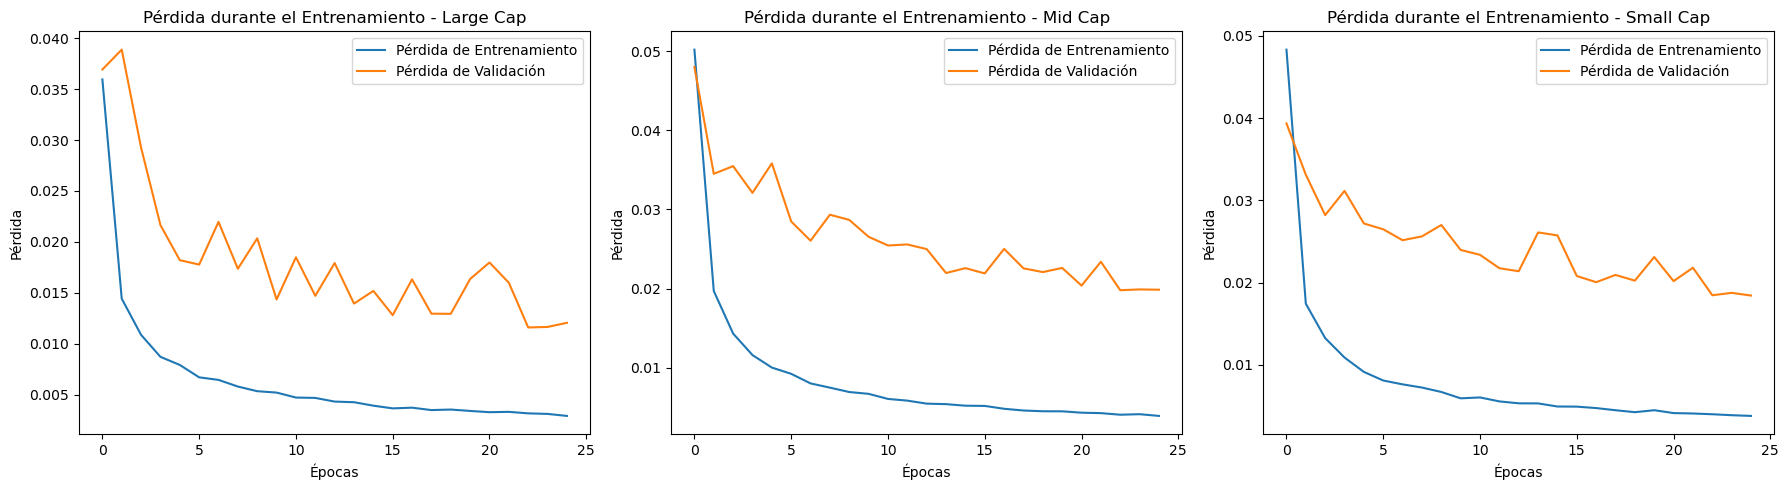

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(history_lc.history['loss'], label='Pérdida de Entrenamiento')
axs[0].plot(history_lc.history['val_loss'], label='Pérdida de Validación')
axs[0].set_title('Pérdida durante el Entrenamiento - Large Cap')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(history_mc.history['loss'], label='Pérdida de Entrenamiento')
axs[1].plot(history_mc.history['val_loss'], label='Pérdida de Validación')
axs[1].set_title('Pérdida durante el Entrenamiento - Mid Cap')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Pérdida')
axs[1].legend()

axs[2].plot(history_sc.history['loss'], label='Pérdida de Entrenamiento')
axs[2].plot(history_sc.history['val_loss'], label='Pérdida de Validación')
axs[2].set_title('Pérdida durante el Entrenamiento - Small Cap')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('Pérdida')
axs[2].legend()

plt.tight_layout()
plt.show()

## Predicción conjunto de prueba

Predecimos los precios de los distintos tickers de las carteras. Hacemos un grafico de los tres primeros de cada cartera para ver las predicciones del modelo junto con los precios reales de los activos seleccionados. Este análisis visual permite evaluar de manera efectiva el desempeño del modelo en la predicción de precios.

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


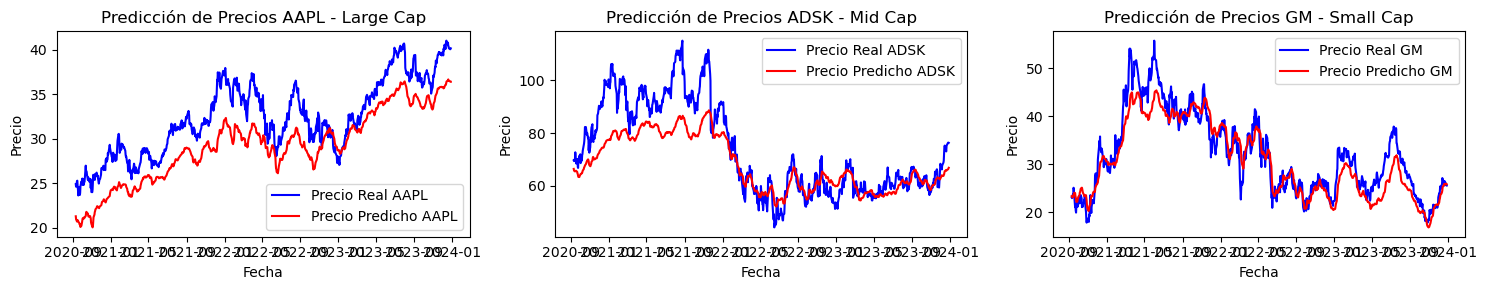

In [5]:
# Cogemos las fechas de X_test para asegurarnos que son las que hemos definido
n_samples = X_test_lc.shape[0]
start_index = len(data_lc) - n_samples
dates_test = data_lc.index[start_index:]

ticker_index = 0

# Para Large Cap
predicted_prices_lc = model_lc.predict(X_test_lc)
predicted_prices_rescaled_lc = scaler_lc.inverse_transform(predicted_prices_lc)[:, ticker_index]
actual_prices_rescaled_lc = scaler_lc.inverse_transform(y_test_lc)[:, ticker_index]

# Para Mid Cap
predicted_prices_mc = model_mc.predict(X_test_mc)
predicted_prices_rescaled_mc = scaler_mc.inverse_transform(predicted_prices_mc)[:, ticker_index]
actual_prices_rescaled_mc = scaler_mc.inverse_transform(y_test_mc)[:, ticker_index]

# Para Small Cap
predicted_prices_sc = model_sc.predict(X_test_sc)
predicted_prices_rescaled_sc = scaler_sc.inverse_transform(predicted_prices_sc)[:, ticker_index]
actual_prices_rescaled_sc = scaler_sc.inverse_transform(y_test_sc)[:, ticker_index]

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].plot(dates_test, actual_prices_rescaled_lc, color='blue', label='Precio Real AAPL')
axs[0].plot(dates_test, predicted_prices_rescaled_lc, color='red', label='Precio Predicho AAPL')
axs[0].set_title('Predicción de Precios AAPL - Large Cap')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Precio')
axs[0].legend()

axs[1].plot(dates_test, actual_prices_rescaled_mc, color='blue', label='Precio Real ADSK')
axs[1].plot(dates_test, predicted_prices_rescaled_mc, color='red', label='Precio Predicho ADSK')
axs[1].set_title('Predicción de Precios ADSK - Mid Cap')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Precio')
axs[1].legend()

axs[2].plot(dates_test, actual_prices_rescaled_sc, color='blue', label='Precio Real GM')
axs[2].plot(dates_test, predicted_prices_rescaled_sc, color='red', label='Precio Predicho GM')
axs[2].set_title('Predicción de Precios GM - Small Cap')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Precio')
axs[2].legend()

plt.tight_layout()
plt.show()

Las predicciones de los modelos siguen de cerca a los precios reales, aunque si existen momentos de discrepancia significativa. Es fundamental destacar que el propósito de esta predicción no es únicamente predecir los precios de los activos en sí, sino que estas predicciones son un paso crucial para la optimización de carteras.

## Optimización Máximo Ratio de Sharpe - LSTM

In [ ]:
from scipy.optimize import minimize

# Función para calcular el ratio de Sharpe
def sharpe_ratio(weights, returns, risk_free_rate=0.000128):
    portfolio_return = np.sum(weights * np.mean(returns, axis=0))
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(np.cov(returns.T), weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_std  # Minimizar la negación del ratio de Sharpe

# Función para optimizar los pesos de la cartera
def optimize_portfolio(predicted_prices_rescaled):

    predicted_returns = np.diff(predicted_prices_rescaled, axis=0) / predicted_prices_rescaled[:-1]
    
    num_assets = predicted_returns.shape[1]
    initial_weights = num_assets * [1. / num_assets]  # Pesos iniciales iguales
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Los pesos deben sumar 1
    bounds = tuple((0, 1) for asset in range(num_assets))  # Pesos entre 0 y 1
    optimized = minimize(sharpe_ratio, initial_weights, args=(predicted_returns,), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimized.x  

# Predicción de precios para las tres carteras y optimización de pesos

predicted_prices_lc = model_lc.predict(X_test_lc)  
predicted_prices_rescaled_lc = scaler_lc.inverse_transform(predicted_prices_lc)  
optimal_weights_lc = optimize_portfolio(predicted_prices_rescaled_lc)

predicted_prices_mc = model_mc.predict(X_test_mc)  
predicted_prices_rescaled_mc = scaler_mc.inverse_transform(predicted_prices_mc) 
optimal_weights_mc = optimize_portfolio(predicted_prices_rescaled_mc)

predicted_prices_sc = model_sc.predict(X_test_sc)  
predicted_prices_rescaled_sc = scaler_sc.inverse_transform(predicted_prices_sc)  
optimal_weights_sc = optimize_portfolio(predicted_prices_rescaled_sc)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filtrar los activos con pesos insignificantes
def filter_small_weights(tickers, weights, threshold=0.0001):
    filtered_tickers = []
    filtered_weights = []
    for ticker, weight in zip(tickers, weights):
        if weight > threshold:  
            filtered_tickers.append(ticker)
            filtered_weights.append(weight)
    return filtered_tickers, filtered_weights

tickers_lc_filtered, weights_lc_filtered = filter_small_weights(large_cap, optimal_weights_lc)
tickers_mc_filtered, weights_mc_filtered = filter_small_weights(mid_cap, optimal_weights_mc)
tickers_sc_filtered, weights_sc_filtered = filter_small_weights(small_cap, optimal_weights_sc)

fig = make_subplots(rows=1, cols=3, subplot_titles=("Large Cap", "Mid Cap", "Small Cap"), specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]])


fig.add_trace(go.Pie(labels=tickers_lc_filtered, values=weights_lc_filtered, name="Large Cap",
                     textinfo='percent+label'),  
              row=1, col=1)

fig.add_trace(go.Pie(labels=tickers_mc_filtered, values=weights_mc_filtered, name="Mid Cap",
                     textinfo='percent+label'),  
              row=1, col=2)

fig.add_trace(go.Pie(labels=tickers_sc_filtered, values=weights_sc_filtered, name="Small Cap",
                     textinfo='percent+label'), 
              row=1, col=3)


fig.update_layout(
    title_text="Distribución de Pesos Óptimos en las Carteras", 
    title_x=0.5, 
    title_font_size=20,
    margin=dict(t=100, b=100, l=50, r=50),  
    showlegend=False  
)

fig.show()

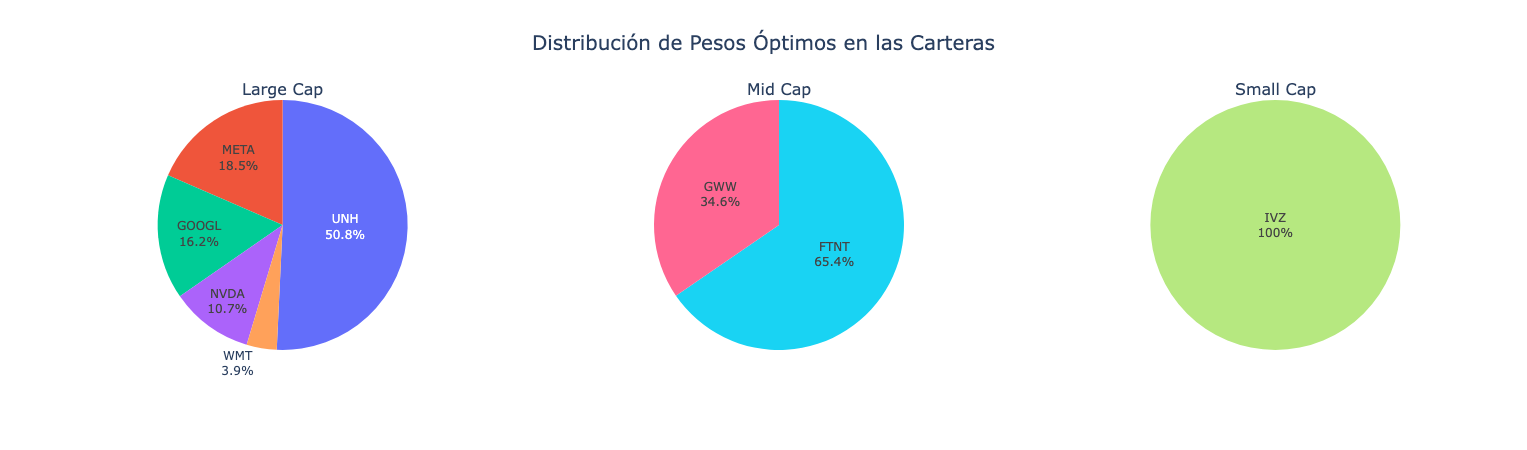

In [6]:
Image(filename='./images/05_lstm.png')

En general, los gráficos muestran una fuerte concentración de pesos en ciertos activos dentro de cada cartera, esta concentración implica un mayor riesgo por falta de diversificación. Vamos a ver como serían los pesos sin usar el modelo de LSTM. 

## Optimización Máximo Ratio de Sharpe - MPT

In [ ]:
# Calcular los rendimientos históricos del periodo de prueba
def calculate_historical_returns(prices):
    returns = prices.pct_change().dropna()
    return returns

# Función para calcular el Ratio de Sharpe es la misma

# Función para optimizar los pesos de la cartera
def optimize_portfolio(historical_returns):
    num_assets = historical_returns.shape[1]
    initial_weights = num_assets * [1. / num_assets]  
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
    bounds = tuple((0, 1) for asset in range(num_assets))  
    optimized = minimize(sharpe_ratio, initial_weights, args=(historical_returns,), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimized.x  


data_lc_mpt = yf.download(large_cap, start='2013-01-01', end='2020-09-10')['Close']
data_mc_mpt = yf.download(mid_cap, start='2013-01-01', end='2020-09-10')['Close']
data_sc_mpt = yf.download(small_cap, start='2013-01-01', end='2020-09-10')['Close']

historical_returns_lc = calculate_historical_returns(data_lc_mpt)
historical_returns_mc = calculate_historical_returns(data_mc_mpt)
historical_returns_sc = calculate_historical_returns(data_sc_mpt)

optimal_weights_lc_mpt = optimize_portfolio(historical_returns_lc)
optimal_weights_mc_mpt = optimize_portfolio(historical_returns_mc)
optimal_weights_sc_mpt = optimize_portfolio(historical_returns_sc)

In [ ]:

tickers_lc_mpt_filtered, weights_lc_mpt_filtered = filter_small_weights(large_cap, optimal_weights_lc_mpt)
tickers_mc_mpt_filtered, weights_mc_mpt_filtered = filter_small_weights(mid_cap, optimal_weights_mc_mpt)
tickers_sc_mpt_filtered, weights_sc_mpt_filtered = filter_small_weights(small_cap, optimal_weights_sc_mpt)

fig = make_subplots(rows=1, cols=3, subplot_titles=("Large Cap", "Mid Cap", "Small Cap"), specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]])

fig.add_trace(go.Pie(labels=tickers_lc_mpt_filtered, values=weights_lc_mpt_filtered, name="Large Cap",
                     textinfo='percent+label'),  
              row=1, col=1)

fig.add_trace(go.Pie(labels=tickers_mc_mpt_filtered, values=weights_mc_mpt_filtered, name="Mid Cap",
                     textinfo='percent+label'),  
              row=1, col=2)

fig.add_trace(go.Pie(labels=tickers_sc_mpt_filtered, values=weights_sc_mpt_filtered, name="Small Cap",
                     textinfo='percent+label'), 
              row=1, col=3)


fig.update_layout(
    title_text="Distribución de Pesos Óptimos en las Carteras", 
    title_x=0.5, 
    title_font_size=20,
    margin=dict(t=100, b=100, l=50, r=50),  
    showlegend=False  
)

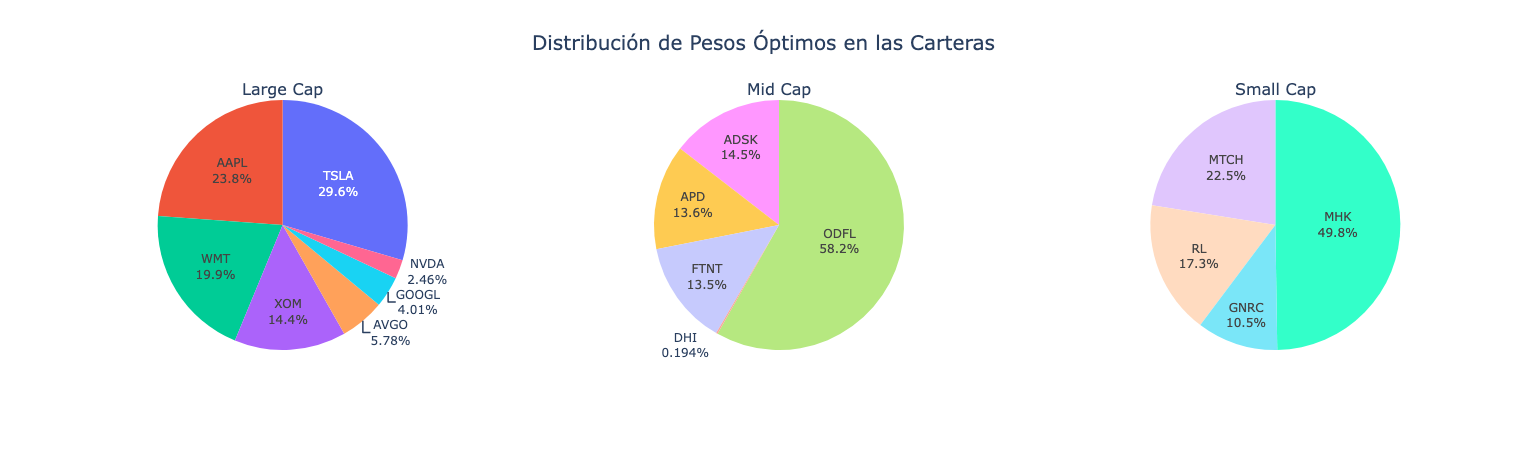

In [7]:
Image(filename='./images/06_lstm.png')

Cuando optimizamos la cartera en base a los datos históricos obtenemos carteras mucho más diversificadas. Veamos como es el rendimiento acumulado en el periodo de prueba, aplicando estos pesos. 

## Resultados

In [ ]:
# Función para descargar los datos y calcular los retornos acumulados para distintas fechas
def get_portfolio_returns(tickers, start_date, end_date, weights):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    daily_returns = data.pct_change().dropna()
    portfolio_returns = daily_returns.dot(weights)
    cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1
    return cumulative_portfolio_returns

# Función para generar el gráfico de resultados
def plot_returns(fig, lstm_returns, mpt_returns, sp500_returns, portfolio_name, row, show_legend):
    fig.add_trace(
        go.Scatter(x=lstm_returns.index, y=lstm_returns,
                   mode='lines', name=f'LSTM', line=dict(color='blue'), legendgroup='LSTM', showlegend=show_legend), 
        row=row, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=mpt_returns.index, y=mpt_returns,
                   mode='lines', name=f'MPT', line=dict(color='green'), legendgroup='MPT', showlegend=show_legend), 
        row=row, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=sp500_returns.index, y=sp500_returns,
                   mode='lines', name='S&P 500', line=dict(dash='dash', color='red'), legendgroup='S&P 500', showlegend=show_legend), 
        row=row, col=1
    )

portfolios = {
    'Large Cap': large_cap,
    'Mid Cap': mid_cap,
    'Small Cap': small_cap
}

optimal_weights_lstm = {
    'Large Cap': optimal_weights_lc,
    'Mid Cap': optimal_weights_mc,
    'Small Cap': optimal_weights_sc
}

optimal_weights_mpt = {
    'Large Cap': optimal_weights_lc_mpt,  
    'Mid Cap': optimal_weights_mc_mpt,  
    'Small Cap': optimal_weights_sc_mpt
}

def get_sp500_returns(start_date, end_date):
    sp500_data = yf.download("^GSPC", start=start_date, end=end_date)['Close']
    sp500_returns = sp500_data.pct_change().dropna()
    return (1 + sp500_returns).cumprod() - 1

sp500_returns = get_sp500_returns('2020-09-10', '2023-12-31')

fig = make_subplots(rows=3, cols=1, subplot_titles=["Large Cap", "Mid Cap", "Small Cap"])

results = pd.DataFrame()

for i, (portfolio_name, tickers) in enumerate(portfolios.items()):

    cumulative_lstm_returns = get_portfolio_returns(tickers, '2020-09-10', '2023-12-31', optimal_weights_lstm[portfolio_name])
    cumulative_mpt_returns = get_portfolio_returns(tickers, '2020-09-10', '2023-12-31', optimal_weights_mpt[portfolio_name])

    portfolio_results = pd.DataFrame({
        f'{portfolio_name} LSTM': cumulative_lstm_returns,
        f'{portfolio_name} MPT': cumulative_mpt_returns
    })
    
    results = pd.concat([results, portfolio_results], axis=1)

    plot_returns(fig, cumulative_lstm_returns, cumulative_mpt_returns, sp500_returns, portfolio_name, i+1, show_legend=(i == 0))

fig.update_layout(
    title_text="Cumulative Returns - LSTM vs MPT vs S&P 500",
    height=900,
    showlegend=True
)

fig.show()

results.to_csv('portfolio_results.csv')

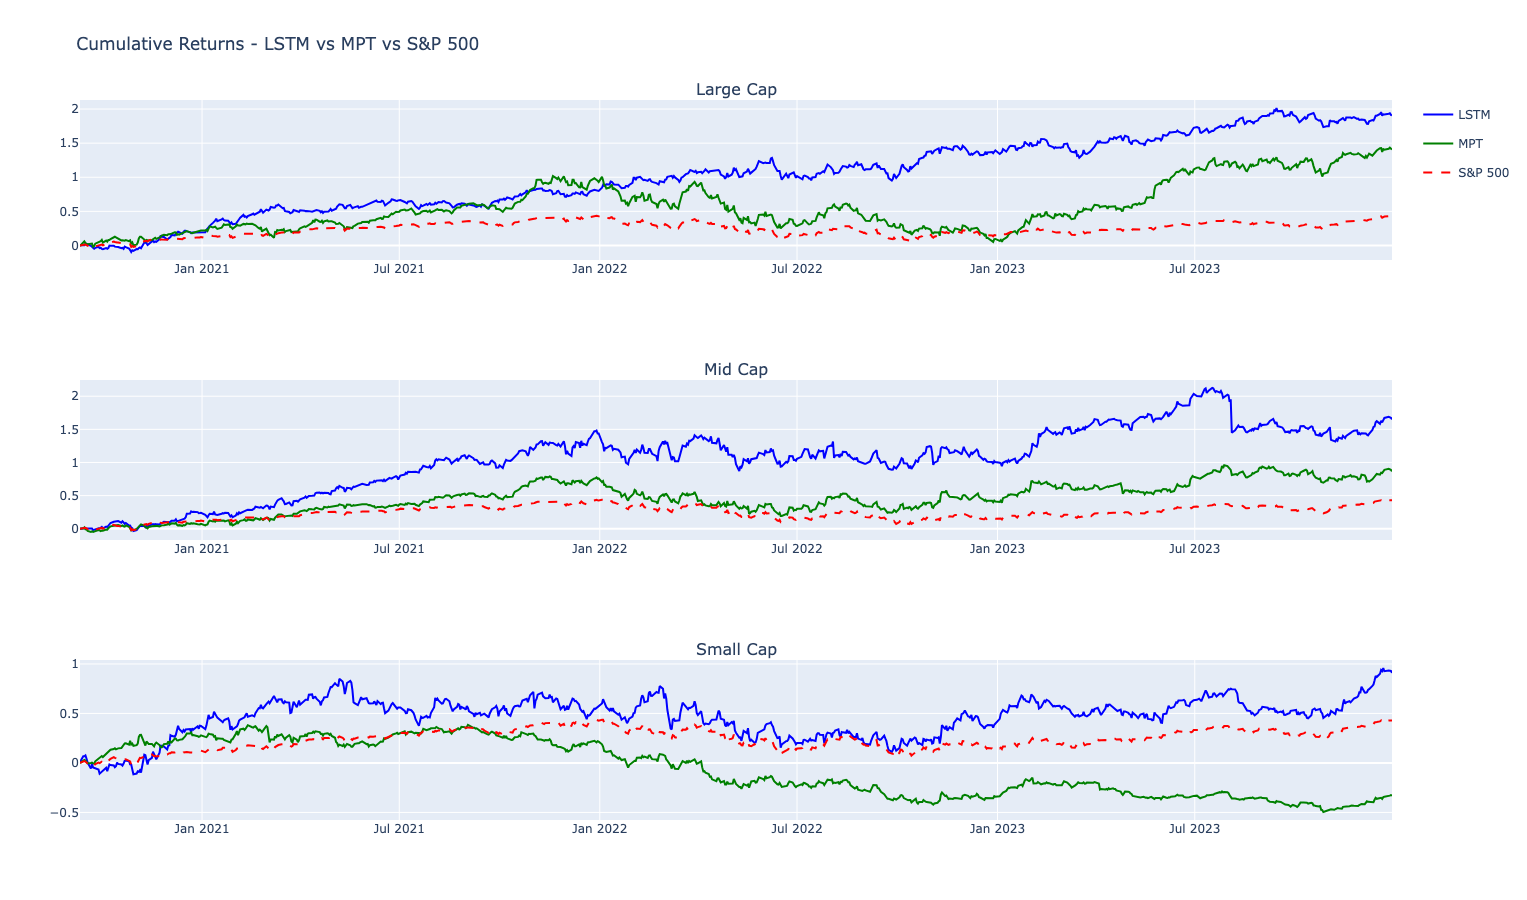

In [8]:
Image(filename='./images/07_lstm.png')

In [ ]:
# Función para descargar los datos y calcular los retornos diarios
def get_daily_returns(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    daily_returns = data.pct_change().dropna()
    return daily_returns

# Función para calcular métricas de rendimiento del portafolio
def calculate_portfolio_metrics(daily_returns, weights, risk_free_rate=0.000128):
    mean_daily_return = daily_returns.mean()
    annualized_return = np.dot(mean_daily_return, weights) * 252
    annualized_volatility = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

# Función para calcular métricas del S&P 500
def calculate_sp500_metrics(start_date, end_date, risk_free_rate=0.000128):
    sp500_returns = get_daily_returns("^GSPC", start_date, end_date)
    mean_daily_return_sp500 = sp500_returns.mean()
    annualized_return_sp500 = mean_daily_return_sp500 * 252  
    annualized_volatility_sp500 = sp500_returns.std() * np.sqrt(252)
    sharpe_ratio_sp500 = (annualized_return_sp500 - risk_free_rate) / annualized_volatility_sp500
    return annualized_return_sp500, annualized_volatility_sp500, sharpe_ratio_sp500

# Función completa para calcular métricas
def calculate_results_for_period(portfolios, optimal_weights, start_date, end_date, risk_free_rate=0.000128):

    results = []
    annualized_return_sp500, annualized_volatility_sp500, sharpe_ratio_sp500 = calculate_sp500_metrics(start_date, end_date, risk_free_rate)
    
    # Procesar cada portafolio
    for portfolio_name, tickers in portfolios.items():

        daily_returns = get_daily_returns(tickers, start_date, end_date)
        weights = optimal_weights[portfolio_name]
        annualized_return_portfolio, annualized_volatility_portfolio, sharpe_ratio_portfolio = calculate_portfolio_metrics(daily_returns, weights, risk_free_rate)

        portfolio_result = {
            "Portfolio": portfolio_name,
            "Annualized Return": annualized_return_portfolio,
            "Annualized Volatility": annualized_volatility_portfolio,
            "Sharpe Ratio": sharpe_ratio_portfolio
        }
        results.append(portfolio_result)

    sp500_result = {
        "Portfolio": "S&P 500",
        "Annualized Return": annualized_return_sp500,
        "Annualized Volatility": annualized_volatility_sp500,
        "Sharpe Ratio": sharpe_ratio_sp500
    }
    results.append(sp500_result)
    results_df = pd.DataFrame(results)
    
    return results_df

portfolios2 = {
    'Large Cap - LSTM': large_cap,
    'Mid Cap - LSTM': mid_cap,
    'Small Cap - LSTM': small_cap,
    'Large Cap - MPT': large_cap,
    'Mid Cap - MPT': mid_cap,
    'Small Cap - MPT': small_cap
}

optimal_weights2 = {
    'Large Cap - LSTM': optimal_weights_lc,
    'Mid Cap - LSTM': optimal_weights_mc,
    'Small Cap - LSTM': optimal_weights_sc,
    'Large Cap - MPT': optimal_weights_lc_mpt,  
    'Mid Cap - MPT': optimal_weights_mc_mpt,  
    'Small Cap - MPT': optimal_weights_sc_mpt
}

results_df = calculate_results_for_period(portfolios2, optimal_weights2, '2020-09-10', '2023-12-31')

In [44]:
results_df

,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio
0,Large Cap - LSTM,0.347785,0.218843,1.588615
1,Mid Cap - LSTM,0.347194,0.318108,1.091034
2,Small Cap - LSTM,0.273589,0.394569,0.693061
3,Large Cap - MPT,0.321569,0.332259,0.967442
4,Mid Cap - MPT,0.227825,0.277034,0.821910
5,Small Cap - MPT,-0.078309,0.295560,-0.265384
6,S&P 500,0.123494,0.175157,0.704321


Las carteras optimizadas con **LSTM** han demostrado un **rendimiento superior** en términos de retorno anualizado y ratio de Sharpe en comparación con las carteras **MPT** y el **S&P 500**. Sin embargo, en los portfolio Mid y Small Cap este mayor rendimiento viene acompañado de una mayor volatilidad, lo que significa que los inversores deben estar dispuestos a aceptar fluctuaciones más pronunciadas en sus portafolios para obtener estos retornos superiores. En el caso de Small Cap, el rendimiento negativo de la cartera MPT sugiere que el enfoque tradicional de optimización no ha sido efectivo en este segmento, mientras que el modelo LSTM ha logrado mitigar mejor las caídas, aunque con mayor riesgo. Estos resultados parecen tener sentido en general. Es lógico que un modelo LSTM, que mira hacia el futuro, pueda superar a la MPT tradicional, especialmente si la LSTM es capaz de capturar patrones en los datos que la MPT podría pasar por alto porque se basa en promedios y covarianzas históricos.

----

## Validación adicional fuera de muestra manteniendo los pesos y reoptimización

En este apartado comprobamos los resultados desde 2023-12-29 a 2024-10-10. Primero lo haremos sin actualizar los pesos (aunque es posible que el modelo LSTM tendrá peor rendimiento ya que se ha optimizado con las predicciones hasta 2023-12-29). Después probaremos a optimizar de nuevo las carteras, prediciendo nuevos precios entre 2023-12-29 a 2024-10-10 y ajustando la recogida de datos históricos hasta 2023-12-29.

### Manteniendo pesos

In [ ]:
sp500_returns = get_sp500_returns('2023-12-31', '2024-12-31')

fig = make_subplots(rows=3, cols=1, subplot_titles=["Large Cap", "Mid Cap", "Small Cap"])

for i, (portfolio_name, tickers) in enumerate(portfolios.items()):

    cumulative_lstm_returns = get_portfolio_returns(tickers, '2023-12-31', '2024-10-10', optimal_weights_lstm[portfolio_name])
    cumulative_mpt_returns = get_portfolio_returns(tickers, '2023-12-31', '2024-10-10', optimal_weights_mpt[portfolio_name])

    portfolio_results = pd.DataFrame({
        f'{portfolio_name} LSTM': cumulative_lstm_returns,
        f'{portfolio_name} MPT': cumulative_mpt_returns
    })
    
    results = pd.concat([results, portfolio_results], axis=1)

    plot_returns(fig, cumulative_lstm_returns, cumulative_mpt_returns, sp500_returns, portfolio_name, i+1, show_legend=(i == 0))

fig.update_layout(
    title_text="Cumulative Returns - LSTM vs MPT vs S&P 500",
    height=900,
    showlegend=True
)

fig.show()

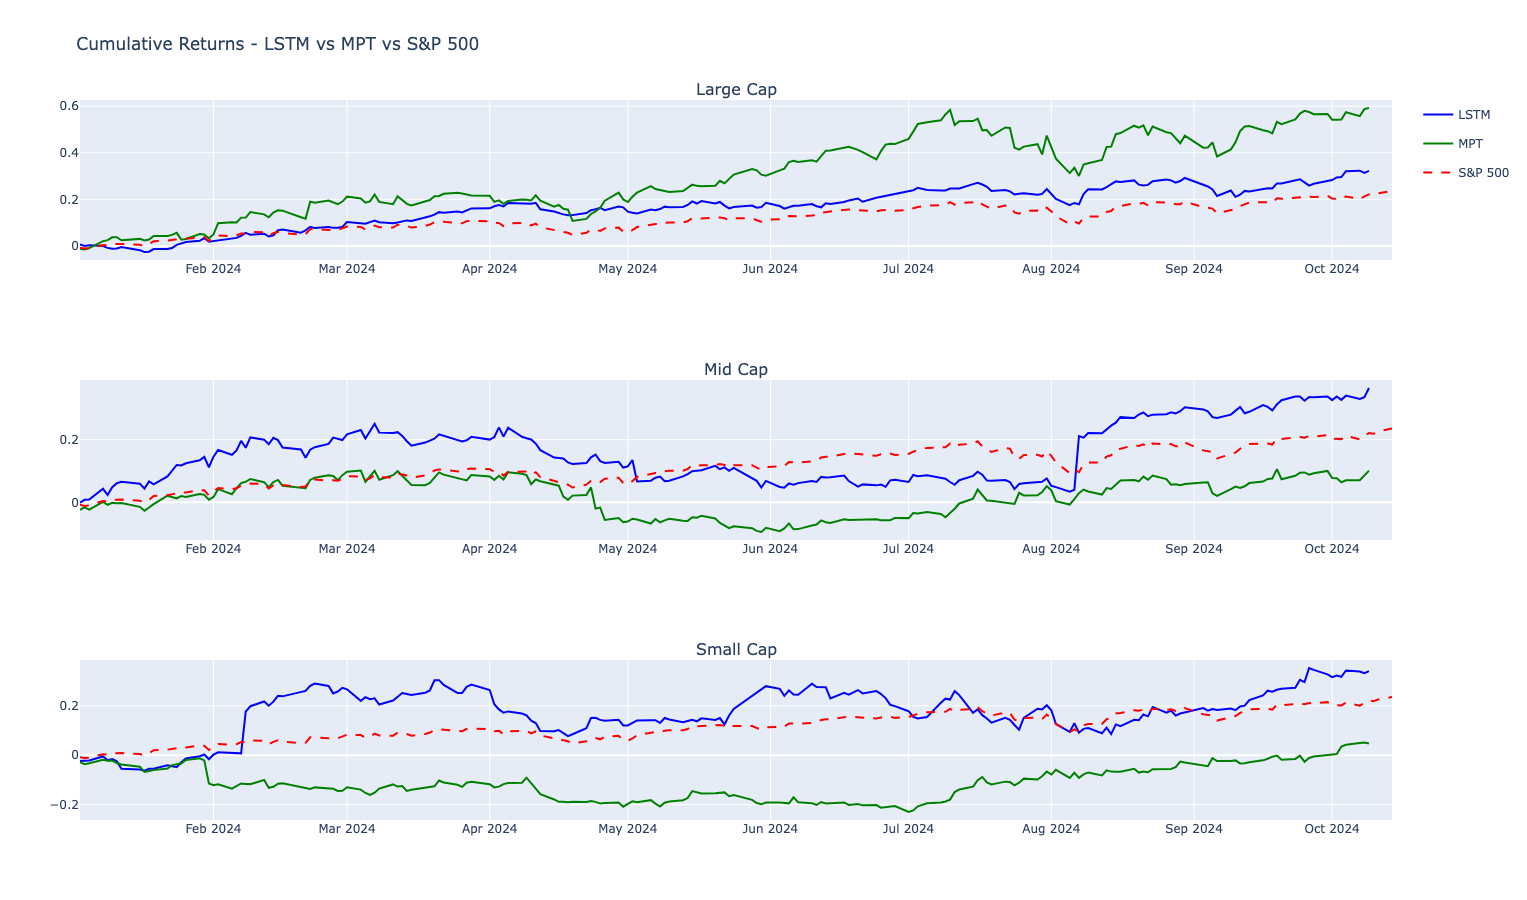

In [9]:
Image(filename='./images/08_lstm.png')

In [ ]:
results_df_frozen_weigths = calculate_results_for_period(portfolios2, optimal_weights2, '2023-12-29', '2024-10-10')

In [26]:
results_df_frozen_weigths

,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio
0,Large Cap - LSTM,0.389634,0.146894,2.651617
1,Mid Cap - LSTM,0.420902,0.281513,1.494690
2,Small Cap - LSTM,0.448919,0.334062,1.343437
3,Large Cap - MPT,0.630593,0.285572,2.207732
4,Mid Cap - MPT,0.125433,0.222344,0.563564
5,Small Cap - MPT,0.077431,0.243406,0.317588
6,S&P 500,0.259055,0.126694,2.043725


### Reoptimización

Repetimos el proceso de optimización con nuevas fechas. Para las carteras MPT, ampliaremos los datos históricos hasta el 2023-12-29.

In [62]:
new_test_data_lc = yf.download(large_cap, start='2023-12-29', end='2024-10-10')['Close']
new_test_data_mc = yf.download(mid_cap, start='2023-12-29', end='2024-10-10')['Close']
new_test_data_sc = yf.download(small_cap, start='2023-12-29', end='2024-10-10')['Close']

X_test_lc_new, y_test_lc_new, _ = normalize_and_create_sequences(new_test_data_lc, sequence_length)
X_test_mc_new, y_test_mc_new, _ = normalize_and_create_sequences(new_test_data_mc, sequence_length)
X_test_sc_new, y_test_sc_new, _ = normalize_and_create_sequences(new_test_data_sc, sequence_length)

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


In [ ]:
predicted_prices_lc_new = model_lc.predict(X_test_lc_new)  
predicted_prices_rescaled_lc_new = scaler_lc.inverse_transform(predicted_prices_lc_new)  
optimal_weights_lc_new = optimize_portfolio(predicted_prices_rescaled_lc_new)

predicted_prices_mc_new = model_mc.predict(X_test_mc_new)  
predicted_prices_rescaled_mc_new = scaler_mc.inverse_transform(predicted_prices_mc_new) 
optimal_weights_mc_new = optimize_portfolio(predicted_prices_rescaled_mc_new)

predicted_prices_sc_new = model_sc.predict(X_test_sc_new)  
predicted_prices_rescaled_sc_new = scaler_sc.inverse_transform(predicted_prices_sc_new)  
optimal_weights_sc_new = optimize_portfolio(predicted_prices_rescaled_sc_new)

In [ ]:
new_data_lc_mpt = yf.download(large_cap, start='2013-01-01', end='2023-12-29')['Close']
new_data_mc_mpt = yf.download(mid_cap, start='2013-01-01', end='2023-12-29')['Close']
new_data_sc_mpt = yf.download(small_cap, start='2013-01-01', end='2023-12-29')['Close']

new_historical_returns_lc = calculate_historical_returns(new_data_lc_mpt)
new_historical_returns_mc = calculate_historical_returns(new_data_mc_mpt)
new_historical_returns_sc = calculate_historical_returns(new_data_sc_mpt)

new_optimal_weights_lc_mpt = optimize_portfolio(new_historical_returns_lc)
new_optimal_weights_mc_mpt = optimize_portfolio(new_historical_returns_mc)
new_optimal_weights_sc_mpt = optimize_portfolio(new_historical_returns_sc)

In [ ]:
new_optimal_weights_lstm = {
    'Large Cap': optimal_weights_lc_new,
    'Mid Cap': optimal_weights_mc_new,
    'Small Cap': optimal_weights_sc_new
}

new_optimal_weights_mpt = {
    'Large Cap': new_optimal_weights_lc_mpt,  
    'Mid Cap': new_optimal_weights_mc_mpt,  
    'Small Cap': new_optimal_weights_sc_mpt
}

sp500_returns = get_sp500_returns('2023-12-31', '2024-10-10')

fig = make_subplots(rows=3, cols=1, subplot_titles=["Large Cap", "Mid Cap", "Small Cap"])

for i, (portfolio_name, tickers) in enumerate(portfolios.items()):

    cumulative_lstm_returns = get_portfolio_returns(tickers, '2023-12-31', '2024-10-10', new_optimal_weights_lstm[portfolio_name])
    cumulative_mpt_returns = get_portfolio_returns(tickers, '2023-12-31', '2024-10-10', new_optimal_weights_mpt[portfolio_name])

    portfolio_results = pd.DataFrame({
        f'{portfolio_name} LSTM': cumulative_lstm_returns,
        f'{portfolio_name} MPT': cumulative_mpt_returns
    })
    
    results = pd.concat([results, portfolio_results], axis=1)
    results.to_csv('new_portofolio_results.csv')

    plot_returns(fig, cumulative_lstm_returns, cumulative_mpt_returns, sp500_returns, portfolio_name, i+1, show_legend=(i == 0))

fig.update_layout(
    title_text="Cumulative Returns - LSTM vs MPT vs S&P 500",
    height=900,
    showlegend=True
)

fig.show()

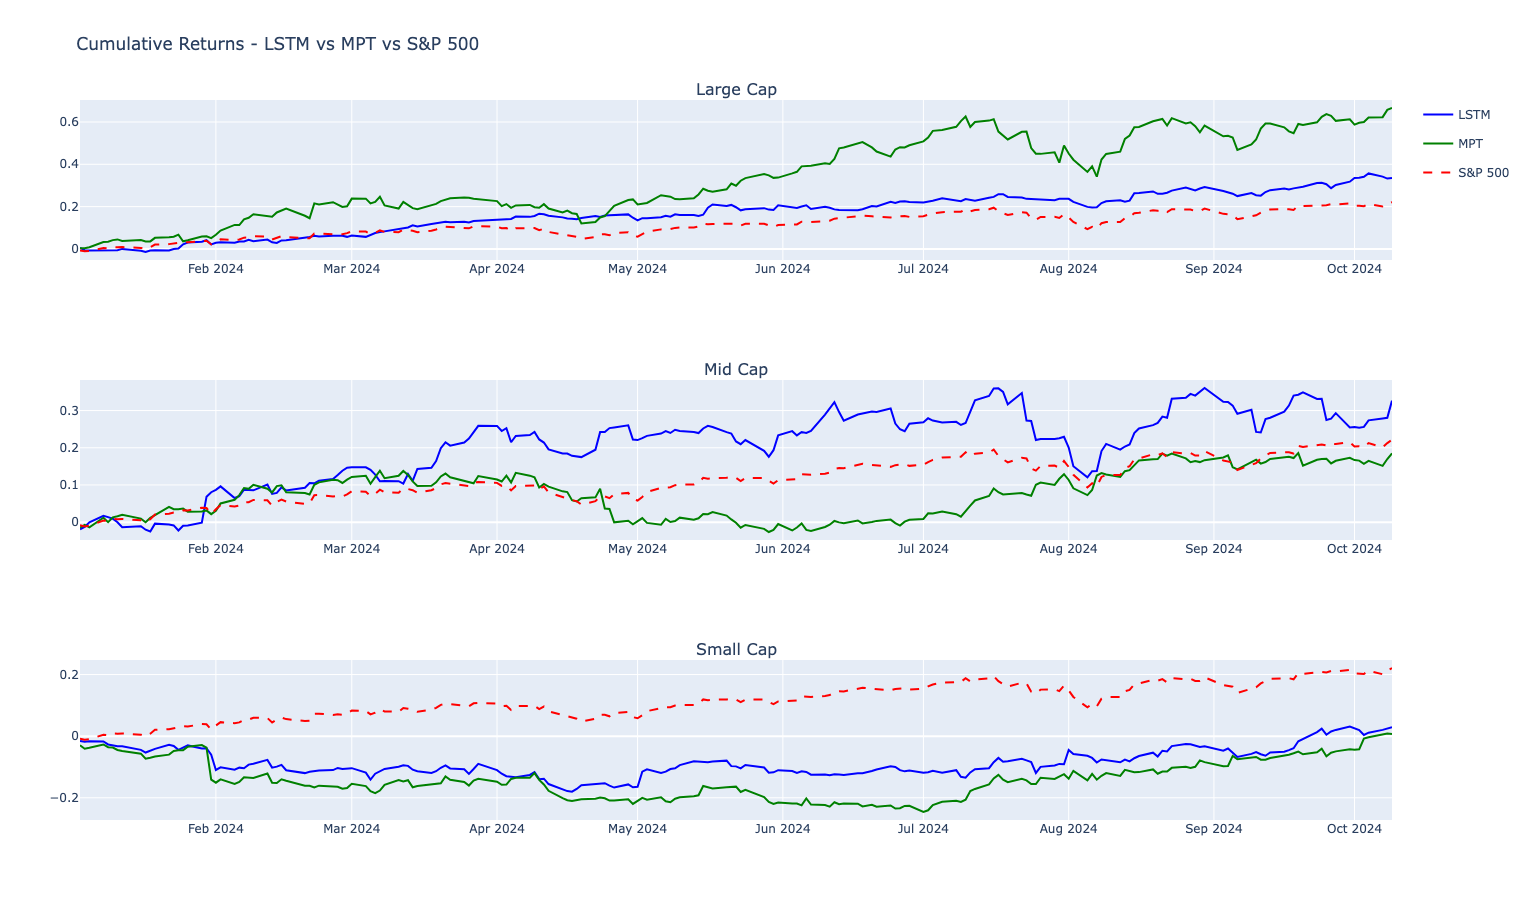

In [10]:
Image(filename='./images/09_lstm.png')

In [ ]:
optimal_weights3 = {
    'Large Cap - LSTM': optimal_weights_lc_new,
    'Mid Cap - LSTM': optimal_weights_mc_new,
    'Small Cap - LSTM': optimal_weights_sc_new,
    'Large Cap - MPT': new_optimal_weights_lc_mpt,  
    'Mid Cap - MPT': new_optimal_weights_mc_mpt,  
    'Small Cap - MPT': new_optimal_weights_sc_mpt
}
results_df_new_weigths = calculate_results_for_period(portfolios2, optimal_weights3, '2023-12-29', '2024-10-10')

### Comparamos resultados reoptimización y manteniendo los pesos

Finalmente, obtenemos los resultados de la rentabilidad, riesgo y ratio de Sharpe anualizados.

#### Resultados reoptimización

In [76]:
results_df_new_weigths

,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio
0,Large Cap - LSTM,0.398275,0.120788,3.296238
1,Mid Cap - LSTM,0.398994,0.257180,1.550924
2,Small Cap - LSTM,0.048029,0.202677,0.236340
3,Large Cap - MPT,0.696212,0.272543,2.554032
4,Mid Cap - MPT,0.222276,0.187389,1.185491
5,Small Cap - MPT,0.020819,0.249058,0.083079
6,S&P 500,0.259055,0.126694,2.043725


#### Resultados con pesos "congelados"

In [42]:
results_df_frozen_weigths

,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio
0,Large Cap - LSTM,0.389634,0.146894,2.651617
1,Mid Cap - LSTM,0.420902,0.281513,1.494690
2,Small Cap - LSTM,0.448919,0.334062,1.343437
3,Large Cap - MPT,0.630593,0.285572,2.207732
4,Mid Cap - MPT,0.125433,0.222344,0.563564
5,Small Cap - MPT,0.077431,0.243406,0.317588
6,S&P 500,0.259055,0.126694,2.043725


En general, las pruebas fuera de muestra confirman que el modelo LSTM ha sido más eficiente que el método MPT, logrando mejores retornos ajustados al riesgo, especialmente en las carteras Large Cap. Sin embargo, tanto las carteras Small Cap como Mid Cap, bajo LSTM y MPT, no lograron superar el Sharpe Ratio del benchmark (S&P 500). Esto indica que, a pesar de las reoptimizaciones, la gestión del riesgo en estas categorías ha sido menos efectiva en comparación con el índice de referencia, destacando los retos que presentan los activos de menor capitalización.